# Cafe Sales Data Cleaning Project

This notebook demonstrates comprehensive data cleaning techniques using pandas on a cafe sales dataset.

## Dataset Overview
- **Source**: Cafe sales transactions
- **Columns**: Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, Transaction Date
- **Issues**: Missing values, inconsistent data, calculation errors, invalid entries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Load and Explore Data

In [35]:
# Load the dataset
df = pd.read_csv('dirty_cafe_sales.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")
df.head()

Dataset shape: (10000, 8)

Column names: ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date']


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [36]:
# Basic information about the dataset
print("Data Types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()

Data Types:
Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


## 2. Identify Data Quality Issues

In [37]:
# Check for missing values and problematic entries
print("Missing Values:")
print(df.isnull().sum())

print("\nEmpty String Values:")
empty_counts = (df == '').sum()
print(empty_counts[empty_counts > 0])

print("\nERROR/UNKNOWN Values:")
for col in df.columns:
    error_count = df[col].astype(str).str.contains('ERROR|UNKNOWN', na=False).sum()
    if error_count > 0:
        print(f"{col}: {error_count} ERROR/UNKNOWN values")

Missing Values:
Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

Empty String Values:
Series([], dtype: int64)

ERROR/UNKNOWN Values:
Item: 636 ERROR/UNKNOWN values
Quantity: 341 ERROR/UNKNOWN values
Price Per Unit: 354 ERROR/UNKNOWN values
Total Spent: 329 ERROR/UNKNOWN values
Payment Method: 599 ERROR/UNKNOWN values
Location: 696 ERROR/UNKNOWN values
Transaction Date: 301 ERROR/UNKNOWN values


In [38]:
# Examine unique values in categorical columns
categorical_cols = ['Item', 'Payment Method', 'Location']

for col in categorical_cols:
    print(f"\n{col} unique values:")
    print(df[col].value_counts(dropna=False))


Item unique values:
Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
NaN          333
ERROR        292
Name: count, dtype: int64

Payment Method unique values:
Payment Method
NaN               2579
Digital Wallet    2291
Credit Card       2273
Cash              2258
ERROR              306
UNKNOWN            293
Name: count, dtype: int64

Location unique values:
Location
NaN         3265
Takeaway    3022
In-store    3017
ERROR        358
UNKNOWN      338
Name: count, dtype: int64


## 3. Data Cleaning Process

In [39]:
# Create a copy for cleaning
df_clean = df.copy()
print(f"Starting with {len(df_clean)} records")

Starting with 10000 records


In [40]:
# Clean categorical columns

# Replace empty strings with NaN
df_clean = df_clean.replace('', np.nan)

# Handle ERROR and UNKNOWN values
df_clean = df_clean.replace(['ERROR', 'UNKNOWN'], np.nan)

# Remove rows where Item is missing (core business data)
df_clean = df_clean.dropna(subset=['Item'])

print(f"After removing missing items: {len(df_clean)} records")

After removing missing items: 9031 records


In [41]:
# Clean numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

for col in numeric_cols:
    # Convert to numeric, errors become NaN
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove rows with missing critical numeric data
df_clean = df_clean.dropna(subset=['Quantity', 'Price Per Unit'])

print(f"After cleaning numeric columns: {len(df_clean)} records")

After cleaning numeric columns: 8147 records


In [42]:
# Fix calculation errors in Total Spent
df_clean['Calculated Total'] = df_clean['Quantity'] * df_clean['Price Per Unit']

# Identify discrepancies
tolerance = 0.01
discrepancies = abs(df_clean['Total Spent'] - df_clean['Calculated Total']) > tolerance

print(f"Found {discrepancies.sum()} calculation discrepancies")

# Use calculated total where original is missing or incorrect
df_clean.loc[df_clean['Total Spent'].isna() | discrepancies, 'Total Spent'] = df_clean['Calculated Total']

# Drop the helper column
df_clean = df_clean.drop('Calculated Total', axis=1)

Found 0 calculation discrepancies


In [43]:
# Clean Transaction Date
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')

# Remove rows with invalid dates
df_clean = df_clean.dropna(subset=['Transaction Date'])

print(f"After cleaning dates: {len(df_clean)} records")

After cleaning dates: 7773 records


In [44]:
# Handle remaining missing values

# Fill missing Payment Method with most common value
most_common_payment = df_clean['Payment Method'].mode()[0]
df_clean['Payment Method'] = df_clean['Payment Method'].fillna(most_common_payment)

# Fill missing Location with most common value
most_common_location = df_clean['Location'].mode()[0]
df_clean['Location'] = df_clean['Location'].fillna(most_common_location)

print(f"Final dataset: {len(df_clean)} records")
print(f"Removed {len(df) - len(df_clean)} records ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")

Final dataset: 7773 records
Removed 2227 records (22.3%)


## 4. Validate Cleaned Data

In [45]:
# Validation checks
print("Data Quality Validation:")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Negative quantities: {(df_clean['Quantity'] < 0).sum()}")
print(f"Negative prices: {(df_clean['Price Per Unit'] < 0).sum()}")
print(f"Invalid dates: {df_clean['Transaction Date'].isnull().sum()}")

# Check calculation accuracy
calc_check = abs(df_clean['Total Spent'] - (df_clean['Quantity'] * df_clean['Price Per Unit'])) > 0.01
print(f"Calculation errors: {calc_check.sum()}")

print("\nData Types After Cleaning:")
print(df_clean.dtypes)

Data Quality Validation:
Missing values: 0
Negative quantities: 0
Negative prices: 0
Invalid dates: 0
Calculation errors: 0

Data Types After Cleaning:
Transaction ID              object
Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object


In [46]:
# Summary statistics
print("Cleaned Data Summary:")
df_clean.describe()

Cleaned Data Summary:


,Quantity,Price Per Unit,Total Spent,Transaction Date
count,7773.000000,7773.000000,7773.000000,7773
mean,3.023929,2.954072,8.935932,2023-07-02 00:53:32.350444032
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00
50%,3.000000,3.000000,8.000000,2023-07-02 00:00:00
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00
std,1.420185,1.275139,5.989323,NaN


## 5. Basic Analysis of Cleaned Data

In [47]:
# Business insights from cleaned data
print("Top 5 Items by Sales Volume:")
print(df_clean['Item'].value_counts().head())

print("\nPayment Method Distribution:")
print(df_clean['Payment Method'].value_counts())

print("\nLocation Distribution:")
print(df_clean['Location'].value_counts())

print(f"\nTotal Revenue: ${df_clean['Total Spent'].sum():.2f}")
print(f"Average Transaction: ${df_clean['Total Spent'].mean():.2f}")

Top 5 Items by Sales Volume:
Item
Juice       1020
Coffee      1012
Cake         989
Salad        985
Sandwich     969
Name: count, dtype: int64

Payment Method Distribution:
Payment Method
Digital Wallet    4238
Cash              1774
Credit Card       1761
Name: count, dtype: int64

Location Distribution:
Location
In-store    5441
Takeaway    2332
Name: count, dtype: int64

Total Revenue: $69459.00
Average Transaction: $8.94


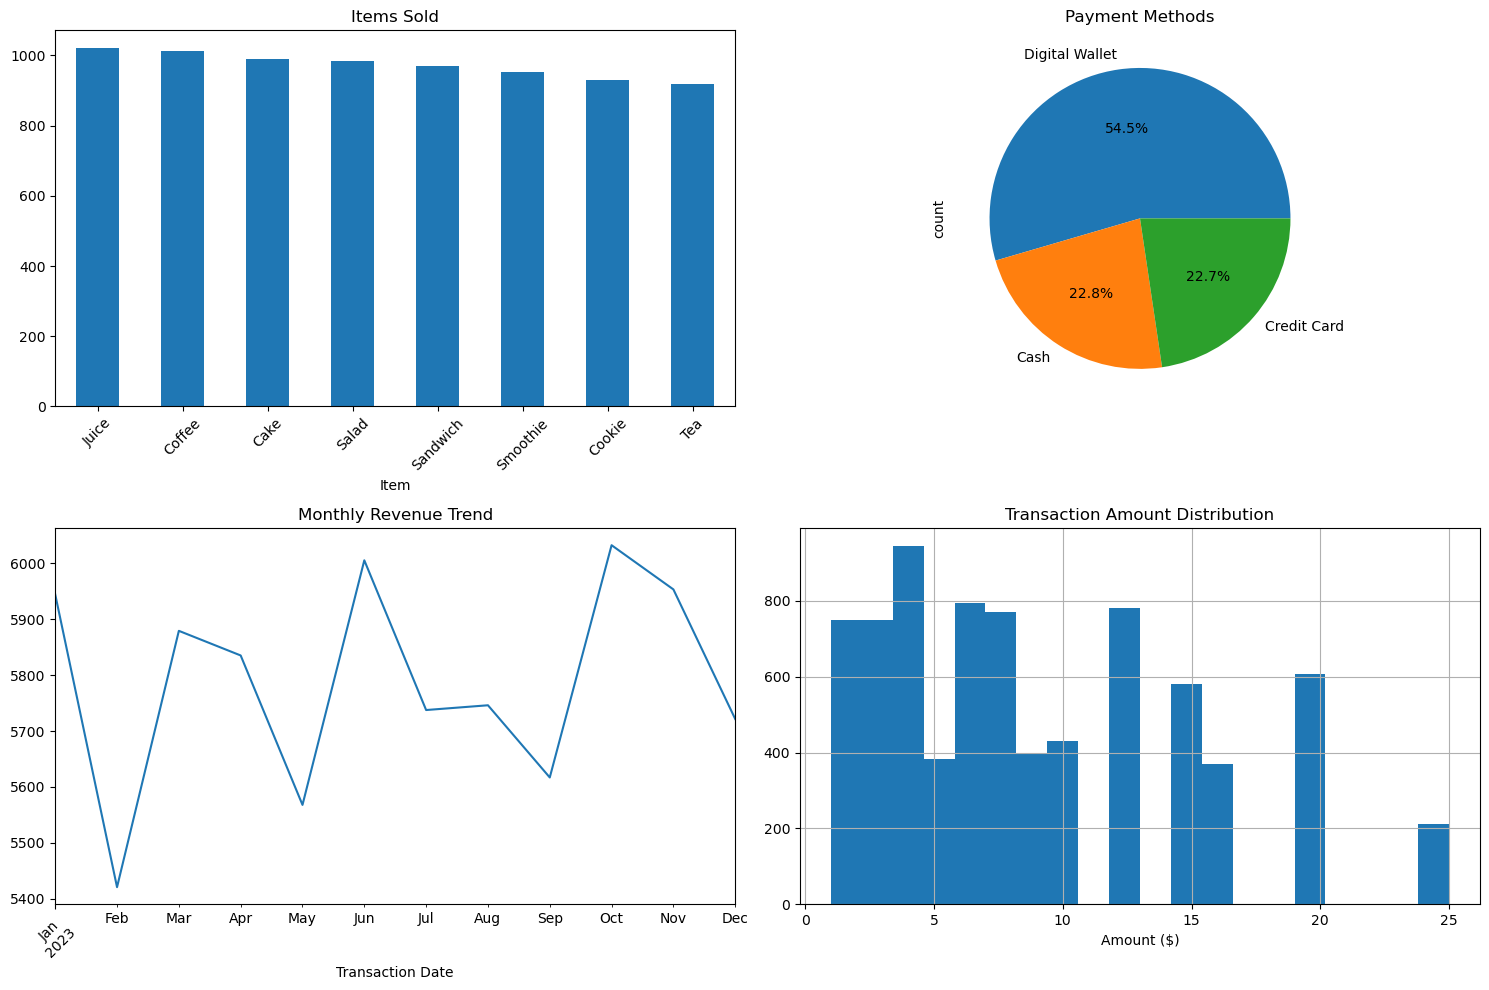

In [48]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Item sales distribution
df_clean['Item'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Items Sold')
axes[0,0].tick_params(axis='x', rotation=45)

# Payment method distribution
df_clean['Payment Method'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Payment Methods')

# Revenue by month
monthly_revenue = df_clean.groupby(df_clean['Transaction Date'].dt.to_period('M'))['Total Spent'].sum()
monthly_revenue.plot(kind='line', ax=axes[1,0])
axes[1,0].set_title('Monthly Revenue Trend')
axes[1,0].tick_params(axis='x', rotation=45)

# Transaction amount distribution
df_clean['Total Spent'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Transaction Amount Distribution')
axes[1,1].set_xlabel('Amount ($)')

plt.tight_layout()
plt.show()

## 6. Export Cleaned Data

In [49]:
# Save cleaned dataset
df_clean.to_csv('clean_cafe_sales.csv', index=False)
print(f"Cleaned dataset saved with {len(df_clean)} records")

# Display final sample
print("\nFinal cleaned data sample:")
df_clean.head()

Cleaned dataset saved with 7773 records

Final cleaned data sample:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,In-store,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


## Summary

### Data Cleaning Steps Performed:
1. **Missing Values**: Replaced empty strings with NaN, removed records with missing core data
2. **Invalid Entries**: Cleaned ERROR/UNKNOWN values in categorical columns
3. **Numeric Data**: Converted to proper numeric types, handled calculation errors
4. **Date Validation**: Converted to datetime format, removed invalid dates
5. **Imputation**: Filled remaining missing values with mode for categorical data

The dataset is now ready for advanced analytics, reporting, and ML applications.